# Churn Prediction for Spotify

In [ ]:
# Import Libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from time import time
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
import joblib
from sklearn.ensemble import RandomForestClassifier
import time

## Loading the dataset

In [116]:
file_path = 'C:\\Users\\naren\\OneDrive\\Documents\\spotify_dataset.json'

df = pd.read_json(file_path, lines=True)

df.head()

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,1538352117000,30,29,NextSong,Logged In,PUT,200,paid,50,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Martha Tilston,Rockpools,277.89016
1,1538352180000,9,8,NextSong,Logged In,PUT,200,free,79,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,Five Iron Frenzy,Canada,236.09424
2,1538352394000,30,29,NextSong,Logged In,PUT,200,paid,51,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Adam Lambert,Time For Miracles,282.82730
3,1538352416000,9,8,NextSong,Logged In,PUT,200,free,80,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,Enigma,Knocking On Forbidden Doors,262.71302
4,1538352676000,30,29,NextSong,Logged In,PUT,200,paid,52,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Daft Punk,Harder Better Faster Stronger,223.60771


In [ ]:
# Information regarding the dataset

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ts             286500 non-null  int64  
 1   userId         286500 non-null  object 
 2   sessionId      286500 non-null  int64  
 3   page           286500 non-null  object 
 4   auth           286500 non-null  object 
 5   method         286500 non-null  object 
 6   status         286500 non-null  int64  
 7   level          286500 non-null  object 
 8   itemInSession  286500 non-null  int64  
 9   location       278154 non-null  object 
 10  userAgent      278154 non-null  object 
 11  lastName       278154 non-null  object 
 12  firstName      278154 non-null  object 
 13  registration   278154 non-null  float64
 14  gender         278154 non-null  object 
 15  artist         228108 non-null  object 
 16  song           228108 non-null  object 
 17  length         228108 non-nul

In [118]:
print(df.dtypes)

ts                 int64
userId            object
sessionId          int64
page              object
auth              object
method            object
status             int64
level             object
itemInSession      int64
location          object
userAgent         object
lastName          object
firstName         object
registration     float64
gender            object
artist            object
song              object
length           float64
dtype: object


## Cleaning and Preparing the data

In [119]:
print(df.isnull().sum())

ts                   0
userId               0
sessionId            0
page                 0
auth                 0
method               0
status               0
level                0
itemInSession        0
location          8346
userAgent         8346
lastName          8346
firstName         8346
registration      8346
gender            8346
artist           58392
song             58392
length           58392
dtype: int64


In [120]:
# Filter the DataFrame to select distinct pages where userId is an empty string
result = df.loc[df['userId'] == '', 'page'].unique()

# Convert the result to a DataFrame if needed
result_df = pd.DataFrame(result, columns=['page'])

# Print or display the result
print(result_df)

                  page
0                 Home
1                 Help
2                Login
3                About
4                Error
5             Register
6  Submit Registration


In [121]:
# Filter the DataFrame to select rows where userId is not null and select the 'page' column
pages_not_empty_userid = df.loc[df['userId'].notnull(), 'page']

# Get unique values from the 'page' column
unique_pages = pages_not_empty_userid.unique()

# Create a DataFrame with the unique pages
unique_pages_df = pd.DataFrame(unique_pages, columns=['page'])

# Print or display the result
print(unique_pages_df)

                         page
0                    NextSong
1             Add to Playlist
2                 Roll Advert
3                   Thumbs Up
4                   Downgrade
5                 Thumbs Down
6                        Home
7                      Logout
8                        Help
9                       Login
10                    Upgrade
11                 Add Friend
12                      About
13                   Settings
14             Submit Upgrade
15           Submit Downgrade
16                      Error
17              Save Settings
18                     Cancel
19  Cancellation Confirmation
20                   Register
21        Submit Registration


In [122]:
df = df.dropna(subset=['userId'])
df = df[df['userId'] != ""]

In [123]:
print("Number of missing values:")
for coln in ['userId', 'sessionId', 'firstName', 'gender', 'lastName', 'location', 'registration', 'userAgent']:
    missing_count = df[coln].isna().sum() + df[coln].isnull().sum() + (df[coln] == "").sum()
    print(f"    {coln}: {missing_count} missing values.")

Number of missing values:
    userId: 0 missing values.
    sessionId: 0 missing values.
    firstName: 0 missing values.
    gender: 0 missing values.
    lastName: 0 missing values.
    location: 0 missing values.
    registration: 0 missing values.
    userAgent: 0 missing values.


In [124]:
null_artist_pages = df[df['artist'].isnull()]['page']

# Drop duplicates
null_artist_unique_pages = null_artist_pages.drop_duplicates()

print(null_artist_unique_pages)

8                  Add to Playlist
11                     Roll Advert
14                       Thumbs Up
35                       Downgrade
47                     Thumbs Down
51                            Home
53                          Logout
139                           Help
144                        Upgrade
176                     Add Friend
307                       Settings
374                 Submit Upgrade
523                          About
930               Submit Downgrade
939                          Error
2176                 Save Settings
20225                       Cancel
20231    Cancellation Confirmation
Name: page, dtype: object


In [125]:
not_null_artist_pages = df[df['artist'].notnull()]['page']

# Drop duplicates
not_null_artist_unique_pages = not_null_artist_pages.drop_duplicates()

# Print or display the result
print(not_null_artist_unique_pages)

0    NextSong
Name: page, dtype: object


In [126]:
# Filter rows where page event is 'NextSong'
df_song = df[df['page'] == 'NextSong']

print("When page event is 'NextSong':")
for coln in ['artist', 'length', 'song']:
    # Count missing values for the current column
    missing_count = df_song[coln].isna().sum() + df_song[coln].isnull().sum() + (df_song[coln] == "").sum()
    print(f"    {coln}: {missing_count} missing values.")

When page event is 'NextSong':
    artist: 0 missing values.
    length: 0 missing values.
    song: 0 missing values.


In [127]:
# Assuming your DataFrame is named df
nan_counts = df.isna().sum()
print(nan_counts)

ts                   0
userId               0
sessionId            0
page                 0
auth                 0
method               0
status               0
level                0
itemInSession        0
location             0
userAgent            0
lastName             0
firstName            0
registration         0
gender               0
artist           50046
song             50046
length           50046
dtype: int64


## Data Analysis for users Listening songs

In [128]:
# Convert timestamp column to datetime
df['ts'] = pd.to_datetime(df['ts'], unit='ms')

# Daily listening time
df['date'] = df['ts'].dt.date
daily_listening_time = df.groupby('date')['length'].sum().reset_index()
daily_listening_time.rename(columns={'length': 'daily_listening_time'}, inplace=True)

# Number of listening sessions per week
df['week'] = df['ts'].dt.isocalendar().week
listening_sessions_per_week = df.groupby('week')['sessionId'].nunique().reset_index()
listening_sessions_per_week.rename(columns={'sessionId': 'listening_sessions_per_week'}, inplace=True)

# Average session duration
session_duration = df.groupby('sessionId')['length'].sum().reset_index()
average_session_duration = session_duration['length'].mean()

# Print or display the results
print("Daily listening time:")
print(daily_listening_time.head())

print("\nNumber of listening sessions per week:")
print(listening_sessions_per_week.head())

print("\nAverage session duration:", average_session_duration)

Daily listening time:
         date  daily_listening_time
0  2018-10-01          844843.93067
1  2018-10-02          873303.29576
2  2018-10-03          790126.76621
3  2018-10-04          924127.86422
4  2018-10-05          904284.06670

Number of listening sessions per week:
   week  listening_sessions_per_week
0    40                          379
1    41                          362
2    42                          393
3    43                          317
4    44                          343

Average session duration: 24578.55629178201


## Data Analysis for users listening by artists

In [129]:
# Convert timestamp column to datetime
df['ts'] = pd.to_datetime(df['ts'], unit='ms')

# Define the specific timeframe (e.g., week or month)
timeframe = 'week'

# Define a function to compute unique artists
def compute_unique_artists(df, timeframe):
    if timeframe == 'week':
        df['period'] = df['ts'].dt.to_period('W')
    elif timeframe == 'month':
        df['period'] = df['ts'].dt.to_period('M')
    else:
        raise ValueError("Invalid timeframe. Please specify 'week' or 'month'.")

    unique_artists_count = df.groupby('period')['artist'].nunique().reset_index()
    unique_artists_count.rename(columns={'artist': f'unique_artists_per_{timeframe}'}, inplace=True)
    return unique_artists_count

# Number of unique artists listened to per week/month
unique_artists_per_timeframe = compute_unique_artists(df, timeframe)

# Playlist diversity
# If data allows, calculate the average number of unique artists per playlist
# Assuming playlist can be defined by sessionId
playlist_diversity = df.groupby('sessionId')['artist'].nunique().mean()

# Print or display the results
print(f"Number of unique artists listened to per {timeframe}:")
print(unique_artists_per_timeframe.head())

print("\nPlaylist diversity:")
print("Average unique artists per playlist:", playlist_diversity)

Number of unique artists listened to per week:
                  period  unique_artists_per_week
0  2018-10-01/2018-10-07                     6569
1  2018-10-08/2018-10-14                     7160
2  2018-10-15/2018-10-21                     7520
3  2018-10-22/2018-10-28                     6818
4  2018-10-29/2018-11-04                     7776

Playlist diversity:
Average unique artists per playlist: 91.10337370242215


# Feature Engineering

Features to be created
1) Confirmation of Cancellation: Identifies churn status (yes/no)
2) Registration Time: Time elapsed since sign-up in seconds
3) Gender: Male (1) or Female (0)
4) User Level: Recent user level, paid (1) or free (0)
5) Unique Artists: Count of different artists listened to
6) Listening Duration: Total time spent on song playback
7) Sessions: Total number of sessions initiated
8) Total Songs: Overall count of songs listened to
9) Artist-Song Metrics: Statistics on song counts per artist
10) Session Duration: Statistics on session duration
11) Song Count per Session: Statistics on song counts per session
12) User Agent: Identification of user agents used
13) Page Events: Count of interactions with various pages
14) Interaction Types: Including actions like Thumbs Up, Thumbs Down, etc.
15) Location: Binary representation of the initial state listed in the location information

In [132]:
def flag_churn_event(page):
    return 1 if page == "Cancellation Confirmation" else 0

# Apply the function to create the churned column
df['churned'] = df['page'].apply(flag_churn_event)

# Print or display the DataFrame
print(df)

                        ts  userId  sessionId      page       auth method  \
0      2018-10-01 00:01:57      30         29  NextSong  Logged In    PUT   
1      2018-10-01 00:03:00       9          8  NextSong  Logged In    PUT   
2      2018-10-01 00:06:34      30         29  NextSong  Logged In    PUT   
3      2018-10-01 00:06:56       9          8  NextSong  Logged In    PUT   
4      2018-10-01 00:11:16      30         29  NextSong  Logged In    PUT   
...                    ...     ...        ...       ...        ...    ...   
286492 2018-11-30 23:55:21  300011        500  NextSong  Logged In    PUT   
286493 2018-11-30 23:55:22  300011        500    Logout  Logged In    PUT   
286497 2018-11-30 23:57:28  300011        500      Home  Logged In    GET   
286498 2018-11-30 23:59:58  300011        500     About  Logged In    GET   
286499 2018-12-01 00:00:11  300011        500  NextSong  Logged In    PUT   

        status level  itemInSession                               location 

## Implementing the Churn feature

In [133]:
total_users = len(df['userId'].unique())
churned_users = df['churned'].sum()

# Calculate the percentage of churned users
churned_users_percentage = (churned_users / total_users) * 100

# Print the percentage of churned users
print("Percentage of Churned Users:", churned_users_percentage)

Percentage of Churned Users: 23.11111111111111


In [134]:
# Calculate churnPhase: cumulative sum of churned events ordered by timestamp for each user
df['churnPhase'] = df.groupby('userId')['churned'].cumsum()

# Calculate churnUser: maximum churned value for each user
df['churnUser'] = df.groupby('userId')['churned'].transform('max')

# Print or display the DataFrame
print(df)

                        ts  userId  sessionId      page       auth method  \
0      2018-10-01 00:01:57      30         29  NextSong  Logged In    PUT   
1      2018-10-01 00:03:00       9          8  NextSong  Logged In    PUT   
2      2018-10-01 00:06:34      30         29  NextSong  Logged In    PUT   
3      2018-10-01 00:06:56       9          8  NextSong  Logged In    PUT   
4      2018-10-01 00:11:16      30         29  NextSong  Logged In    PUT   
...                    ...     ...        ...       ...        ...    ...   
286492 2018-11-30 23:55:21  300011        500  NextSong  Logged In    PUT   
286493 2018-11-30 23:55:22  300011        500    Logout  Logged In    PUT   
286497 2018-11-30 23:57:28  300011        500      Home  Logged In    GET   
286498 2018-11-30 23:59:58  300011        500     About  Logged In    GET   
286499 2018-12-01 00:00:11  300011        500  NextSong  Logged In    PUT   

        status level  itemInSession                               location 

In [135]:
# Define the flag_churn_event function
def flag_churn_event(page):
    return 1 if page == "Cancellation Confirmation" else 0

# Apply the function to create the churned column
df['churned'] = df['page'].apply(flag_churn_event)

# Group by userId and get the maximum churned value
churned_df = df.groupby('userId')['churned'].max().reset_index()

# Save churned_df to a new DataFrame
new_df = churned_df.copy()

# Print the DataFrame
print(new_df.head(14))

    userId  churned
0       10        0
1      100        0
2   100001        1
3   100002        0
4   100003        1
5   100004        0
6   100005        1
7   100006        1
8   100007        1
9   100008        0
10  100009        1
11  100010        0
12  100011        1
13  100012        1


## Defining User Level

In [136]:
df_sorted = df.sort_values(by='ts', ascending=False)

# Remove duplicate rows based on 'userId', keeping only the latest level for each user
latest_levels = df_sorted.drop_duplicates(subset='userId', keep='first')[['userId', 'level']].copy()

# Convert 'level' column to binary values ('paid'->1, 'free'->0)
latest_levels['level'] = latest_levels['level'].apply(lambda x: 1 if x == 'paid' else 0)

# Print the number of rows
print(f"{len(latest_levels)} rows.")

# Print the first 5 rows
print(latest_levels.head())

225 rows.
        userId  level
226525  100002      1
248693  200008      1
213690     152      1
286499  300011      1
213689     138      1


## Defining time suince registration and gender

In [137]:
# Assuming df_sub2_table is your pandas DataFrame
df['ts'] = pd.to_datetime(df['ts'], unit='ms')  # Convert timestamps to datetime objects

# Group by userId and perform aggregations
time_since_reg = (df.groupby('userId')
                    .agg(max_ts=('ts', 'max'), 
                         avg_registration=('registration', 'mean'),
                         gender=('gender', 'first'))  # Assuming gender is categorical
                 )

# Calculate time since registration in seconds
time_since_reg['time_since_regi'] = (time_since_reg['max_ts'] - pd.to_datetime(time_since_reg['avg_registration'], unit='ms')).dt.total_seconds()

# Convert gender to binary (1 for male, 0 for female)
time_since_reg['gender'] = time_since_reg['gender'].apply(lambda x: 1 if x == 'M' else 0)

# Drop unnecessary columns
time_since_reg.drop(['max_ts', 'avg_registration'], axis=1, inplace=True)

print(f"{len(time_since_reg)} rows.")
print(time_since_reg.head(14))

225 rows.
        gender  time_since_regi
userId                         
10           1        4472293.0
100          1        5605094.0
100001       0        3870739.0
100002       0       13864787.0
100003       0        1965437.0
100004       0       14898823.0
100005       1        7360899.0
100006       0         788587.0
100007       0        9969490.0
100008       0        5894948.0
100009       1        3234667.0
100010       0        4807612.0
100011       1         446266.0
100012       1        3719746.0


## Defining User engagement features in Spotify

In [138]:
# Calculate engagement metrics for each user
engagement = df.groupby('userId').agg(
    num_artists_dist=('artist', 'nunique'),             # Number of distinct artists
    tot_length=('length', 'sum'),                       # Total length of songs listened
    num_sessions=('sessionId', 'nunique'),              # Number of distinct sessions
    num_songs=('song', 'count'),                        # Total number of songs
    num_songs_dist=('song', 'nunique'),                 # Number of distinct songs
    num_events=('page', 'count')                        # Number of page events
)

# Print the number of rows
print(f"{len(engagement)} rows.")

# Print the first 5 rows
print(engagement.head(12))

225 rows.
        num_artists_dist    tot_length  num_sessions  num_songs  \
userId                                                            
10                   565  166866.37251             6        673   
100                 1705  672877.85659            35       2682   
100001               125   35073.74215             4        133   
100002               184   49559.91810             4        195   
100003                50   12306.41932             2         51   
100004               733  231480.38929            21        942   
100005               149   37037.12201             5        154   
100006                26    5854.89105             1         26   
100007               357  104495.32492             9        423   
100008               623  191396.79602             6        772   
100009               442  129745.78968            10        518   
100010               252   66940.89735             7        275   

        num_songs_dist  num_events  
userId        

## Statistics for user engagement features

In [139]:
df_filtered = df[df['artist'].notnull()]
songs_per_artist = df_filtered.groupby(['userId', 'artist']).size().reset_index(name='num_songs')
per_artist = songs_per_artist.groupby('userId')['num_songs'].agg(['max', 'mean', 'std']).reset_index()
per_artist.columns = ['userId', 'max_songs_per_artist', 'avg_songs_per_artist', 'std_songs_per_artist']
per_artist.fillna(0, inplace=True)
print(f"{len(per_artist)} rows.")
print(per_artist.head(20))

225 rows.
    userId  max_songs_per_artist  avg_songs_per_artist  std_songs_per_artist
0       10                     9              1.191150              0.645986
1      100                    26              1.573021              1.647868
2   100001                     3              1.064000              0.276615
3   100002                     3              1.059783              0.279953
4   100003                     2              1.020000              0.141421
5   100004                     8              1.285130              0.781801
6   100005                     2              1.033557              0.180693
7   100006                     1              1.000000              0.000000
8   100007                     5              1.184874              0.570330
9   100008                     7              1.239165              0.691432
10  100009                     5              1.171946              0.506045
11  100010                     3              1.091270            

In [140]:
# Calculate session time in seconds and number of songs per session
per_session = df.groupby(['userId', 'sessionId']).agg(
    num_songs=('song', 'count'),
    time=('ts', lambda x: (x.max() - x.min()).total_seconds())  # Calculate session time in seconds
).reset_index()

# Calculate statistics per user
per_session_stats = per_session.groupby('userId').agg(
    max_songs_per_session=('num_songs', 'max'),
    avg_songs_per_session=('num_songs', 'mean'),
    std_songs_per_session=('num_songs', 'std'),
    max_time_per_session=('time', 'max'),
    avg_time_per_session=('time', 'mean'),
    std_time_per_session=('time', 'std')
).fillna(0)

print(f"{len(per_session_stats)} rows.")
print(per_session_stats.head(14))

225 rows.
        max_songs_per_session  avg_songs_per_session  std_songs_per_session  \
userId                                                                        
10                        381             112.166667             133.324291   
100                       256              76.628571              74.168761   
100001                     53              33.250000              16.839933   
100002                    175              48.750000              84.428964   
100003                     49              25.500000              33.234019   
100004                    218              44.857143              55.023891   
100005                     51              30.800000              20.945167   
100006                     26              26.000000               0.000000   
100007                    163              47.000000              55.366958   
100008                    491             128.666667             182.128160   
100009                    165             

## Defining user device feature

In [141]:
def extract_device(user_agent):
    return "user_agent_" + user_agent.split('(')[1].replace(";", " ").split(" ")[0]

df['userAgent'] = df['userAgent'].apply(extract_device)

agent_counts = df.groupby(['userId', 'userAgent']).size().reset_index(name='user_agent_usage')
user_totals = agent_counts.groupby('userId')['user_agent_usage'].transform('sum')
agent_counts['user_agent_usage'] = agent_counts['user_agent_usage'] / user_totals

agents = agent_counts.pivot_table(index='userId', columns='userAgent', values='user_agent_usage', fill_value=0)

print(f"{len(agents)} rows.")
print(agents.head())

225 rows.
userAgent  user_agent_Macintosh  user_agent_Windows  user_agent_X11  \
userId                                                                
10                            1                   0               0   
100                           0                   1               0   
100001                        1                   0               0   
100002                        0                   1               0   
100003                        0                   1               0   

userAgent  user_agent_compatible  user_agent_iPad  user_agent_iPhone  
userId                                                                
10                             0                0                  0  
100                            0                0                  0  
100001                         0                0                  0  
100002                         0                0                  0  
100003                         0                0                 

## Page event features

In [142]:
pages_to_exclude = ['Cancel', 'Downgrade', 'Cancellation Confirmation', 'Upgrade']

def transform_page(page):
    return "page_" + page.replace(" ", "_").lower()

df_filtered = df[~df['page'].isin(pages_to_exclude)]
df_filtered['page'] = df_filtered['page'].apply(transform_page)

pages = df_filtered.groupby(['userId', 'page']).size().unstack(fill_value=0)
pages['page_up_down_ratio'] = pages['page_thumbs_up'] / (pages['page_thumbs_down'] + 0.1)

print(f"{len(pages)} rows.")
print(pages.head(20))

225 rows.
page    page_about  page_add_friend  page_add_to_playlist  page_error  \
userId                                                                  
10               2               12                     9           0   
100             12               49                    61           3   
100001           0                2                     3           1   
100002           0                1                     5           0   
100003           0                0                     2           0   
100004           0               19                    23           2   
100005           0                3                     3           0   
100006           0                4                     1           0   
100007           0               17                     9           0   
100008           3               17                    30           0   
100009           1                7                    12           0   
100010           1                4      

C:\Users\naren\AppData\Local\Temp\ipykernel_16300\604778028.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['page'] = df_filtered['page'].apply(transform_page)


## Fraction of page event user

In [143]:
# Calculate the total number of page events for each user
pages['total'] = pages.sum(axis=1)

# Calculate the fraction of each page event by each user
for col in pages.columns:
    if col not in ['userId', 'total', 'page_up_down_ratio']:
        new_col_name = col[:5] + 'frac_' + col[5:]
        pages[new_col_name] = pages[col] / pages['total']

# Drop the 'total' column
pages.drop(columns=['total'], inplace=True)

print(f"{len(pages)} rows.")
print(pages.filter(regex='_frac').head(14))

225 rows.
page    page_frac_about  page_frac_add_friend  page_frac_add_to_playlist  \
userId                                                                     
10             0.002509              0.015056                   0.011292   
100            0.003764              0.015368                   0.019131   
100001         0.000000              0.010706                   0.016059   
100002         0.000000              0.003759                   0.018797   
100003         0.000000              0.000000                   0.018868   
100004         0.000000              0.015445                   0.018697   
100005         0.000000              0.014134                   0.014134   
100006         0.000000              0.093126                   0.023282   
100007         0.000000              0.033067                   0.017506   
100008         0.003219              0.018239                   0.032187   
100009         0.001509              0.010561                   0.018104   
10

In [144]:
print(pages.head(12))

page    page_about  page_add_friend  page_add_to_playlist  page_error  \
userId                                                                  
10               2               12                     9           0   
100             12               49                    61           3   
100001           0                2                     3           1   
100002           0                1                     5           0   
100003           0                0                     2           0   
100004           0               19                    23           2   
100005           0                3                     3           0   
100006           0                4                     1           0   
100007           0               17                     9           0   
100008           3               17                    30           0   
100009           1                7                    12           0   
100010           1                4                

## Defining Location Features

In [145]:
region = pd.read_csv('https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv')
region.to_csv("region.csv", index=False)
print(region.head(5))

        State State Code Region            Division
0      Alaska         AK   West             Pacific
1     Alabama         AL  South  East South Central
2    Arkansas         AR  South  West South Central
3     Arizona         AZ   West            Mountain
4  California         CA   West             Pacific


In [ ]:
# Find the user's geographical division based on the first listed location state
func_locations = lambda x: x.split(', ')[1].split('-')[0]
func_location_names = lambda x: "location_" + x.replace(" ", "_").lower()

# Apply the functions to extract and format the location data
df['location'] = df['location'].apply(func_locations)

# Merge with the region DataFrame to get the geographical division
locations = df.merge(region, left_on='location', right_on='State Code', how='left') \
              .groupby('userId')['Division'] \
              .apply(lambda x: x.value_counts().idxmax()) \
              .reset_index(name='location')

# Pivot to get counts of each geographical division per user
locations = locations.pivot_table(index='userId', columns='location', aggfunc='size', fill_value=0)

print(f"{len(locations)} rows.")
print(locations.head(12))

## Joining all the engineered features

In [147]:
# Merge the first two DataFrames
merged_df = pd.merge(latest_levels, time_since_reg, on='userId', how='inner').drop_duplicates(subset='userId')

# Define a list of DataFrames to merge
dataframes_to_merge = [new_df, engagement, per_artist, per_session_stats, agents, pages, locations]

# Merge the rest of the DataFrames
for dataframe in dataframes_to_merge:
    merged_df = pd.merge(merged_df, dataframe, on='userId', how='inner').drop_duplicates(subset='userId')
    

print(merged_df.head(12))

    userId  level  gender  time_since_regi  churned  num_artists_dist  \
0   100002      1       0       13864787.0        0               184   
1   200008      1       0        9951882.0        0              1159   
2      152      1       1        2681824.0        0               982   
3   300011      1       0        5285640.0        0              2491   
4      138      1       1        5756546.0        0              1332   
5       39      1       0       14594814.0        0              3544   
6       30      1       1        5448958.0        0              1018   
7       56      1       1        5871144.0        0               571   
8       81      1       1        8528806.0        0              1307   
9       93      1       1        6137205.0        0               509   
10      92      0       0        7216893.0        0              2904   
11     145      1       0        8840288.0        0               868   

      tot_length  num_sessions  num_songs  num_son

In [ ]:
# Example of merged features with all columns also showing one of the id which is 100010

In [148]:
print(merged_df.columns)

# Filter the DataFrame to get the row with userId = 100010
user_100010 = merged_df[merged_df['userId'] == '100010']

# Set display options to show all columns
pd.set_option('display.max_columns', None)

# Print the entire row
print(user_100010)

Index(['userId', 'level', 'gender', 'time_since_regi', 'churned',
       'num_artists_dist', 'tot_length', 'num_sessions', 'num_songs',
       'num_songs_dist', 'num_events', 'max_songs_per_artist',
       'avg_songs_per_artist', 'std_songs_per_artist', 'max_songs_per_session',
       'avg_songs_per_session', 'std_songs_per_session',
       'max_time_per_session', 'avg_time_per_session', 'std_time_per_session',
       'user_agent_Macintosh', 'user_agent_Windows', 'user_agent_X11',
       'user_agent_compatible', 'user_agent_iPad', 'user_agent_iPhone',
       'page_about', 'page_add_friend', 'page_add_to_playlist', 'page_error',
       'page_help', 'page_home', 'page_logout', 'page_nextsong',
       'page_roll_advert', 'page_save_settings', 'page_settings',
       'page_submit_downgrade', 'page_submit_upgrade', 'page_thumbs_down',
       'page_thumbs_up', 'page_up_down_ratio', 'page_frac_about',
       'page_frac_add_friend', 'page_frac_add_to_playlist', 'page_frac_error',
       'page_

## Correlation Analysis for highly related features

In [149]:
# Convert 'std_time_per_session' column to numeric, handling errors by setting them to NaN
merged_df['std_time_per_session'] = pd.to_numeric(merged_df['std_time_per_session'], errors='coerce')

# Drop any remaining rows with NaN values
merged_df.dropna(inplace=True)

# Calculate the correlation matrix
corr_matrix = merged_df.corr()

# Initialize a list to store correlated columns
correlated_cols = []

# Iterate over columns in the correlation matrix
for col in corr_matrix.columns:
    # Find correlated features with absolute correlation >= 0.5
    correlated = corr_matrix.drop(col, axis=0).loc[corr_matrix[col].abs() >= 0.5].index.tolist()
    if len(correlated) > 0:
        correlated_cols.append(col)

# Print the correlated columns
print(correlated_cols)

['level', 'num_artists_dist', 'tot_length', 'num_sessions', 'num_songs', 'num_songs_dist', 'num_events', 'max_songs_per_artist', 'avg_songs_per_artist', 'std_songs_per_artist', 'max_songs_per_session', 'avg_songs_per_session', 'std_songs_per_session', 'max_time_per_session', 'avg_time_per_session', 'std_time_per_session', 'user_agent_Macintosh', 'user_agent_Windows', 'page_about', 'page_add_friend', 'page_add_to_playlist', 'page_error', 'page_help', 'page_home', 'page_logout', 'page_nextsong', 'page_roll_advert', 'page_save_settings', 'page_settings', 'page_submit_downgrade', 'page_submit_upgrade', 'page_thumbs_down', 'page_thumbs_up', 'page_up_down_ratio', 'page_frac_home', 'page_frac_nextsong', 'page_frac_roll_advert', 'page_frac_settings', 'page_frac_submit_downgrade']


In [150]:
# Assuming dataset_pd is your DataFrame containing the data
# Assuming correlated_cols is the list of correlated columns you obtained earlier

# Calculate the correlation matrix for the correlated columns
corr = merged_df[correlated_cols].corr()

# Initialize a list to store features to be removed
cols_to_remove = []

# Iterate over columns in the correlation matrix
for col in corr.columns:
    # Find maximum correlation with any remaining feature
    max_corr = corr[col].iloc[corr.columns.get_loc(col) + 1:].max()
    # Check if the maximum correlation is greater than or equal to 0.8
    if max_corr >= 0.9:
        cols_to_remove.append(col)

print(f"Highly correlated features that should be removed:\n\n{cols_to_remove}\n\n")

# Get the list of features to keep by removing the features to be removed from the original list of columns
cols_to_keep = merged_df.columns.drop(cols_to_remove).tolist()

print(f"Features to keep:\n\n{cols_to_keep}")

Highly correlated features that should be removed:

['num_artists_dist', 'tot_length', 'num_sessions', 'num_songs', 'num_songs_dist', 'num_events', 'max_songs_per_artist', 'avg_songs_per_artist', 'std_songs_per_artist', 'max_songs_per_session', 'avg_songs_per_session', 'std_songs_per_session', 'max_time_per_session', 'page_add_friend', 'page_add_to_playlist', 'page_help', 'page_home', 'page_logout', 'page_nextsong']


Features to keep:

['userId', 'level', 'gender', 'time_since_regi', 'churned', 'avg_time_per_session', 'std_time_per_session', 'user_agent_Macintosh', 'user_agent_Windows', 'user_agent_X11', 'user_agent_compatible', 'user_agent_iPad', 'user_agent_iPhone', 'page_about', 'page_error', 'page_roll_advert', 'page_save_settings', 'page_settings', 'page_submit_downgrade', 'page_submit_upgrade', 'page_thumbs_down', 'page_thumbs_up', 'page_up_down_ratio', 'page_frac_about', 'page_frac_add_friend', 'page_frac_add_to_playlist', 'page_frac_error', 'page_frac_help', 'page_frac_home', 

## Heat Map

Correlations among the remaining features:


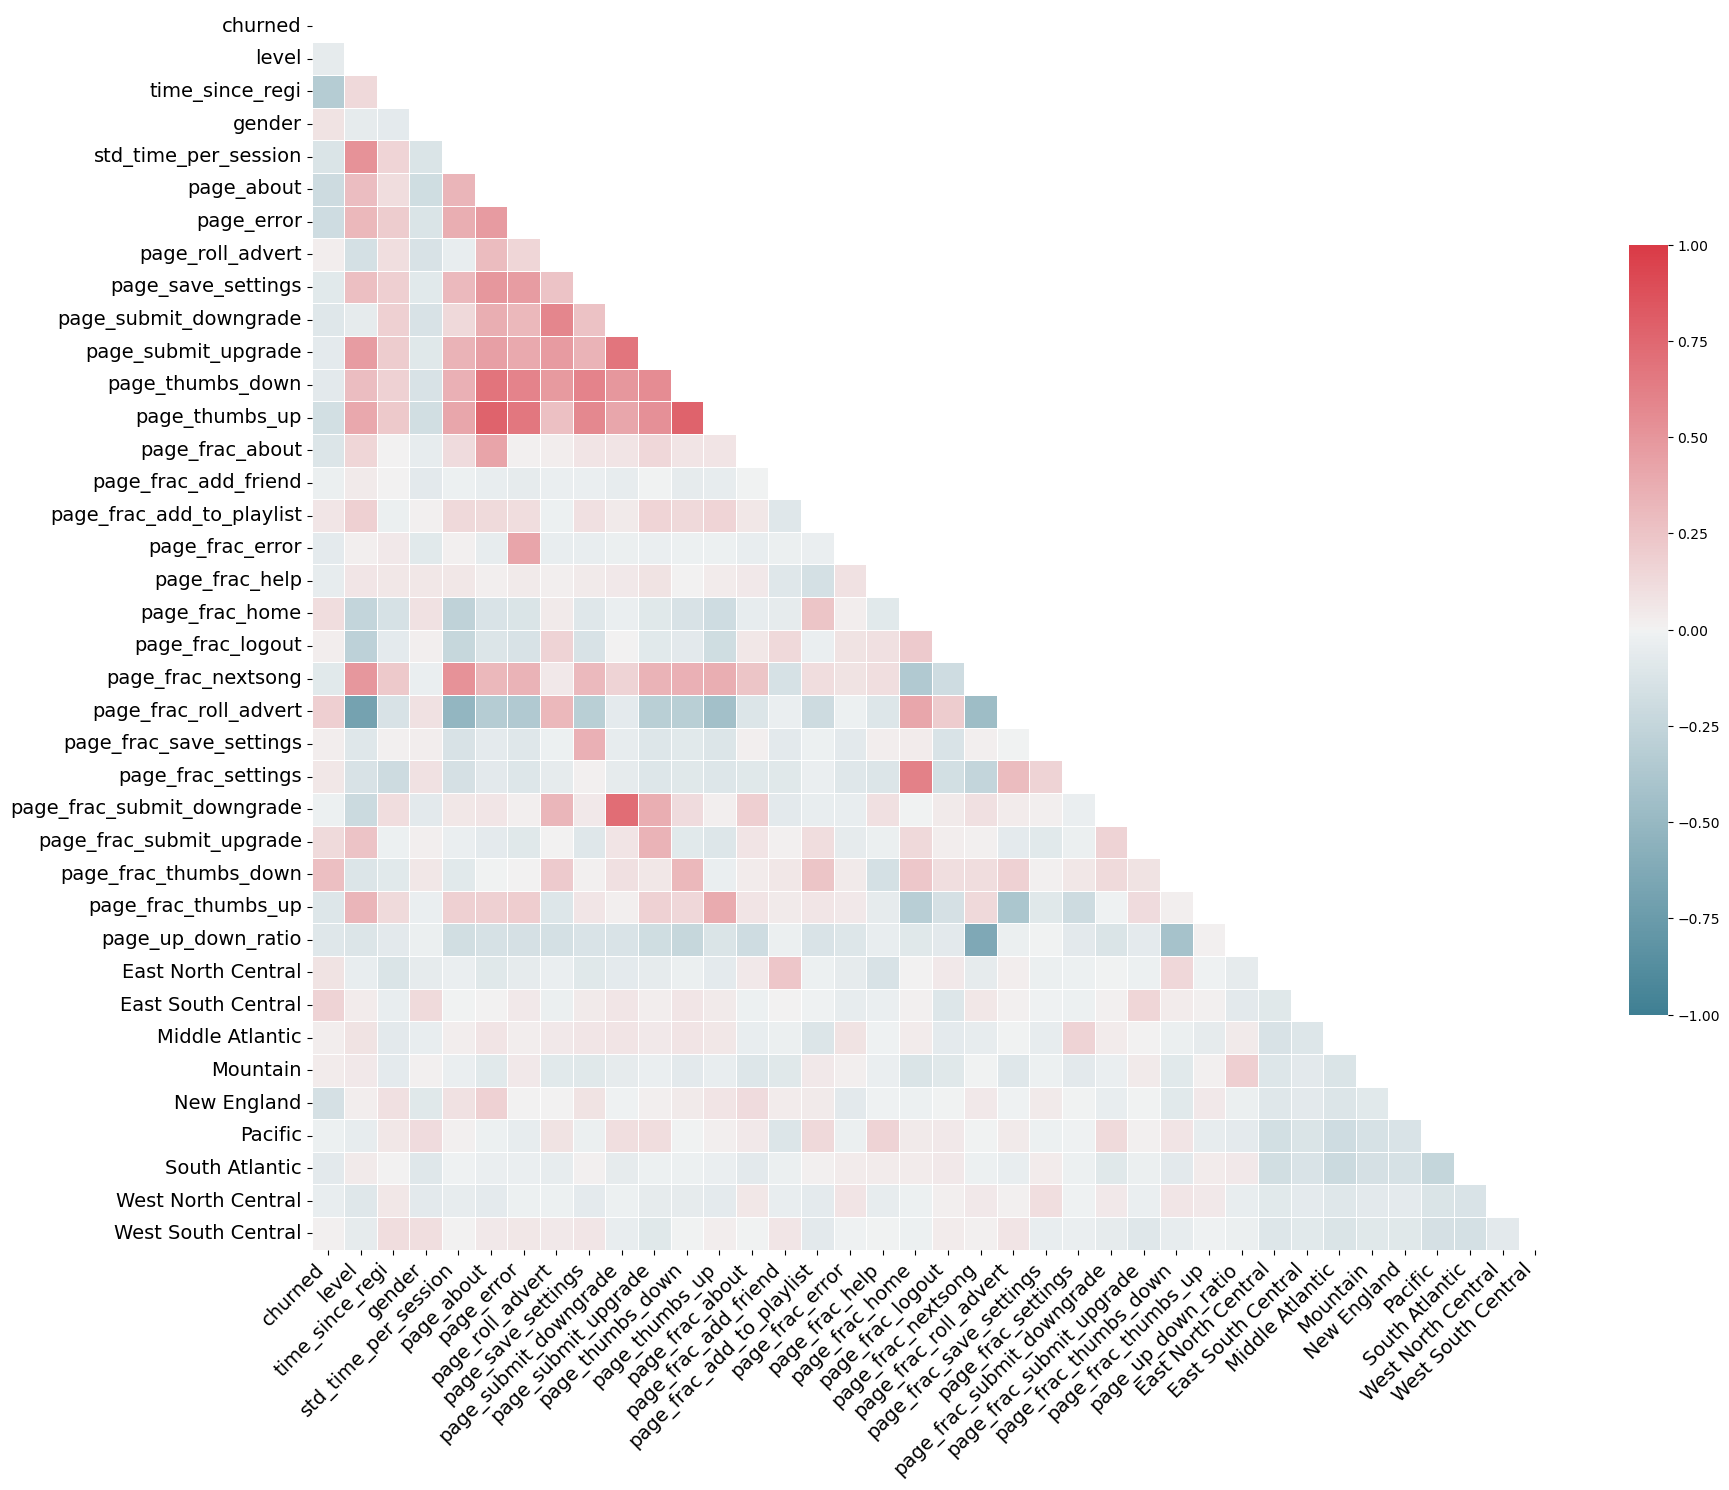

Index(['userId', 'churned', 'level', 'time_since_regi', 'gender',
       'std_time_per_session', 'user_agent_Macintosh', 'user_agent_Windows',
       'user_agent_X11', 'user_agent_compatible', 'user_agent_iPad',
       'user_agent_iPhone', 'page_about', 'page_error', 'page_roll_advert',
       'page_save_settings', 'page_submit_downgrade', 'page_submit_upgrade',
       'page_thumbs_down', 'page_thumbs_up', 'page_frac_about',
       'page_frac_add_friend', 'page_frac_add_to_playlist', 'page_frac_error',
       'page_frac_help', 'page_frac_home', 'page_frac_logout',
       'page_frac_nextsong', 'page_frac_roll_advert',
       'page_frac_save_settings', 'page_frac_settings',
       'page_frac_submit_downgrade', 'page_frac_submit_upgrade',
       'page_frac_thumbs_down', 'page_frac_thumbs_up', 'page_up_down_ratio',
       'East North Central', 'East South Central', 'Middle Atlantic',
       'Mountain', 'New England', 'Pacific', 'South Atlantic',
       'West North Central', 'West South Cen

In [151]:
cols_to_keep_new = ['userId', 'churned', 'level', 'time_since_regi', 'gender', 'std_time_per_session', 
    'user_agent_Macintosh', 'user_agent_Windows', 'user_agent_X11', 'user_agent_compatible',
    'user_agent_iPad', 'user_agent_iPhone', 'page_about', 
    'page_error', 'page_roll_advert', 'page_save_settings', 'page_submit_downgrade', 
    'page_submit_upgrade', 'page_thumbs_down', 'page_thumbs_up', 'page_frac_about', 
    'page_frac_add_friend', 'page_frac_add_to_playlist', 'page_frac_error', 
    'page_frac_help', 'page_frac_home', 'page_frac_logout', 'page_frac_nextsong', 
    'page_frac_roll_advert', 'page_frac_save_settings', 'page_frac_settings', 
    'page_frac_submit_downgrade', 'page_frac_submit_upgrade', 'page_frac_thumbs_down', 
    'page_frac_thumbs_up', 'page_up_down_ratio' , 'East North Central', 'East South Central',
    'Middle Atlantic', 'Mountain', 'New England', 'Pacific', 'South Atlantic', 'West North Central', 'West South Central'
]

merged_df = merged_df.loc[:, cols_to_keep_new]

print("Correlations among the remaining features:")
cols_to_keep_corr = [coln for coln in cols_to_keep_new if ('user_agent' not in coln) & ('userId' not in coln)]
corr_remaining = merged_df[cols_to_keep_corr].corr()


# Generate a mask for the upper triangle
mask = np.zeros_like(corr_remaining, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(
    corr_remaining, mask=mask, cmap=cmap, center=0,
    vmin=-1, vmax=1, 
    square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
    xticklabels=cols_to_keep_corr,
    yticklabels=cols_to_keep_corr)
plt.xticks(rotation=45, ha='right', fontsize=14) 
plt.yticks(fontsize=14)

plt.show()


print(merged_df.columns)

## Feature Transformation

In [152]:
# Confirm missing values
missing_value_count = merged_df.isnull().sum().sum()
print(f"{missing_value_count} missing values left.")

0 missing values left.


Examine feature distributions:


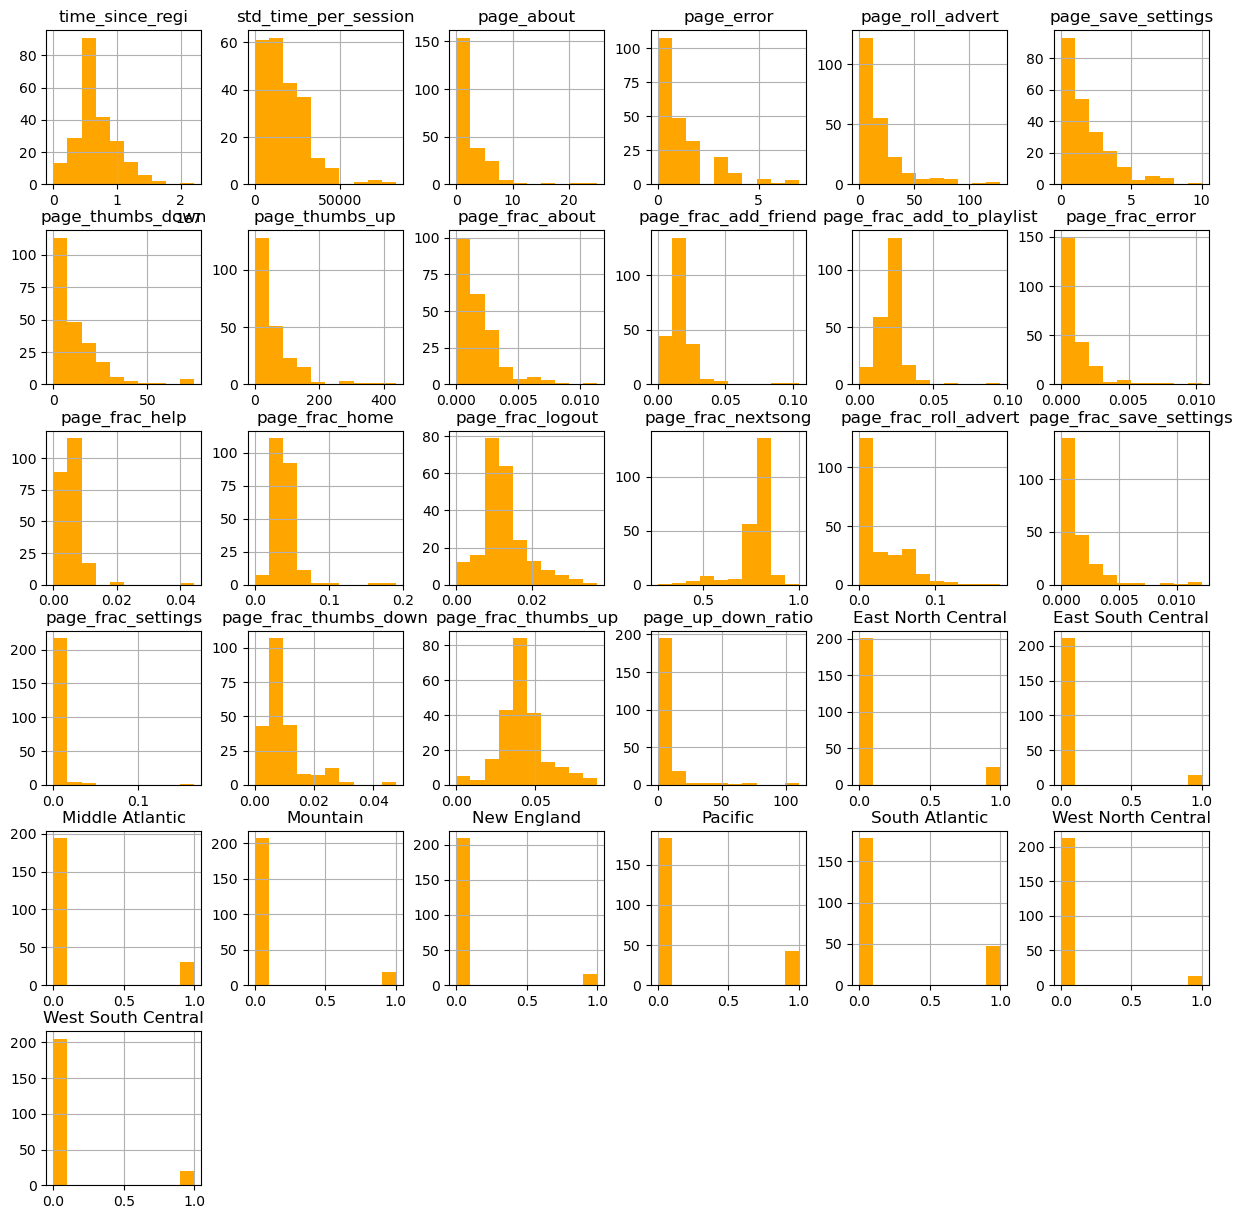

In [153]:
# Examine feature distributions (excluding binary features and submit page events)
print("Examine feature distributions:")
col_names = [coln for coln in merged_df.columns if 
             ('churn' not in coln) and 
             ('level' not in coln) and
             ('userId' not in coln) and
             ('gender' not in coln) and
             ('user_agent_' not in coln) and
             ('location_' not in coln) and
             ('_submit_' not in coln)
            ]
merged_df[col_names].hist(figsize=(15,15),color='orange');

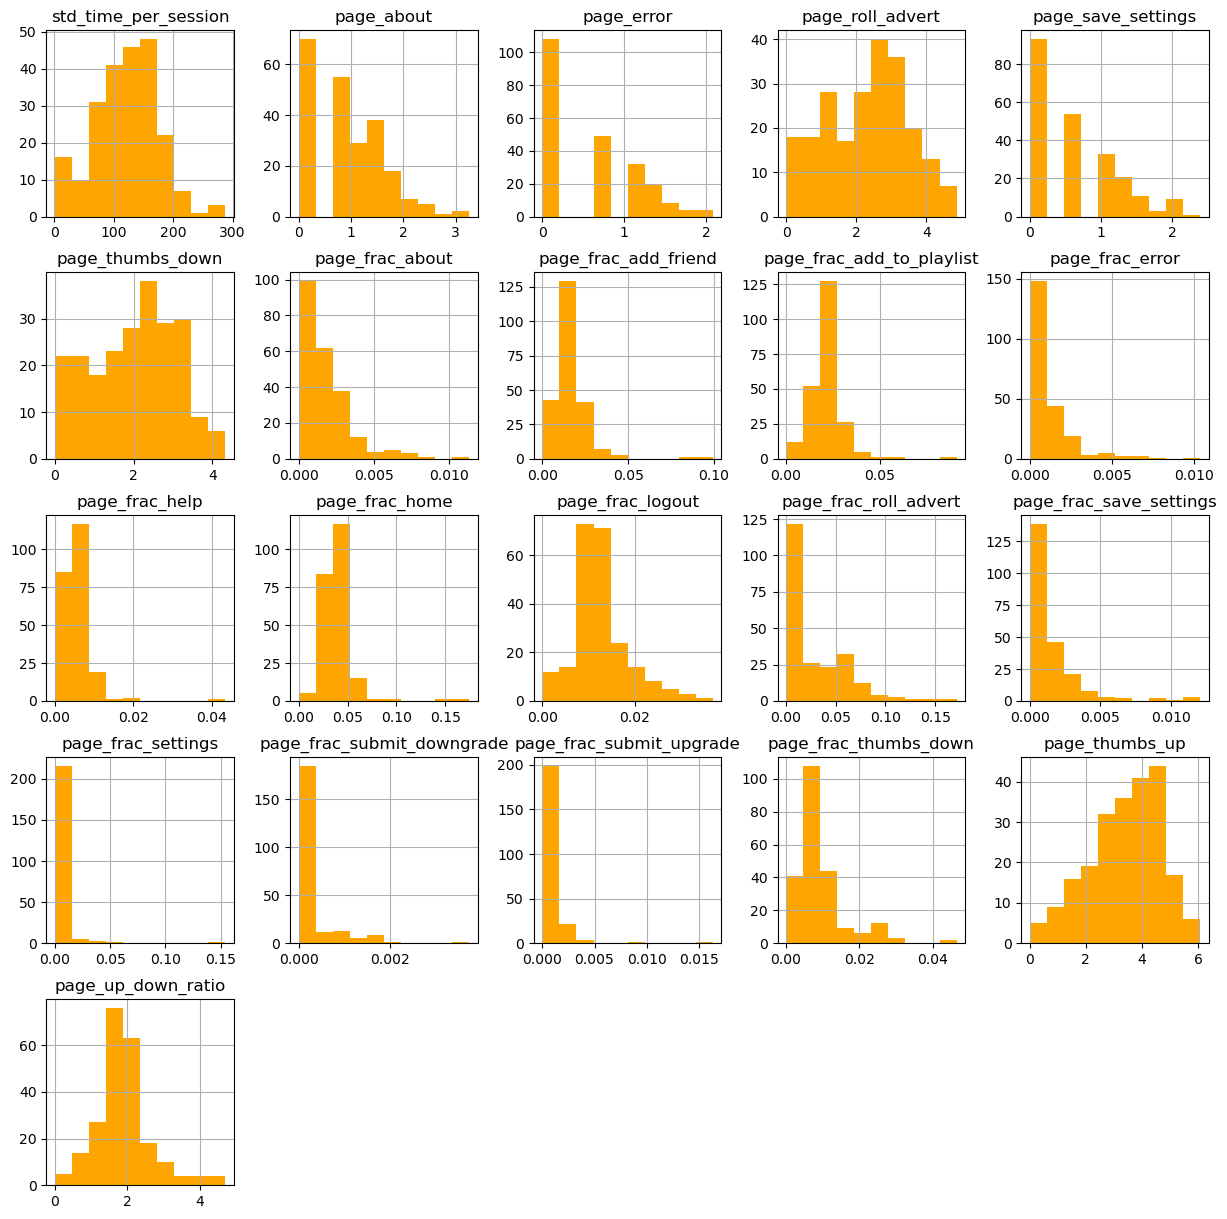

In [154]:
# Assuming dataset_pd is your DataFrame containing the data

to_sqrt = ['std_time_per_session']
to_log = [
    'page_about', 'page_error', 'page_roll_advert', 'page_save_settings', 
    'page_thumbs_down', 'page_frac_about', 'page_frac_add_friend', 
    'page_frac_add_to_playlist', 'page_frac_error', 'page_frac_help', 
    'page_frac_home', 'page_frac_logout', 'page_frac_roll_advert', 
    'page_frac_save_settings', 'page_frac_settings', 
    'page_frac_submit_downgrade', 'page_frac_submit_upgrade', 
    'page_frac_thumbs_down', 'page_thumbs_up',
    'page_up_down_ratio'
]

# Apply transformations to specified columns
for col_name in to_sqrt:
    merged_df[col_name] = np.sqrt(merged_df[col_name] + 1)

for col_name in to_log:
    merged_df[col_name] = np.log(merged_df[col_name] + 1)

# Plot the histograms to examine feature distributions
merged_df[to_sqrt + to_log].hist(figsize=(15,15), color='orange');

In [ ]:
# saving the file after preprocessing into the local system

In [155]:
# Save merged_df to a CSV file
merged_df.to_csv('merged_df.csv', index=False)
print(merged_df)

# Create a copy of merged_df
Processed_df = merged_df.copy()

     userId  churned  level  time_since_regi  gender  std_time_per_session  \
0    100002        0      1       13864787.0       0            145.764727   
1    200008        0      1        9951882.0       0            161.942597   
2       152        0      1        2681824.0       1            161.243919   
3    300011        0      1        5285640.0       0            130.230507   
4       138        0      1        5756546.0       1            205.205202   
..      ...      ...    ...              ...     ...                   ...   
220  300007        1      1         998240.0       1              1.000000   
221  100024        1      0        2351951.0       1              1.000000   
222     135        0      0        6228539.0       0              1.000000   
223  100001        1      0        3870739.0       0             61.522799   
224  100011        1      0         446266.0       1              1.000000   

     user_agent_Macintosh  user_agent_Windows  user_agent_X11  

## Modelling

### Train_test_Split

In [156]:
# Rename 'churn' column to 'label' and convert it to float
Processed_df.rename(columns={'churned': 'churn'}, inplace=True)
Processed_df['churn'] = Processed_df['churn'].astype(float)

# Define feature columns
feature_cols = [col for col in Processed_df.columns if col not in ['churn', 'userId']]

# If you want to scale the features, you can use StandardScaler
scaler = StandardScaler()
Processed_df[feature_cols] = scaler.fit_transform(Processed_df[feature_cols])

# Now dataset contains 'label' column and scaled 'feature' columns

In [157]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(Processed_df[feature_cols], Processed_df['churn'], test_size=0.2, random_state=42)

# Concatenate 'userId' with the corresponding features for train and test sets
train = pd.concat([X_train, y_train, Processed_df['userId'].iloc[X_train.index]], axis=1)
test = pd.concat([X_test, y_test, Processed_df['userId'].iloc[X_test.index]], axis=1)

# Display the shapes of the train and test sets
print("Train set shape:", train.shape)
print("Test set shape:", test.shape)

Train set shape: (180, 45)
Test set shape: (45, 45)


#### 

In [158]:
def buildCV(classifier, paramGrid):
    '''
    Build a cross validation pipeline
    
    INPUT
    classifier: untrained machine learning classifier
    paramGrid: a grid of parameters to search over
    
    OUTPUT
    grid_search: GridSearchCV object
    '''
    # Configure an ML pipeline
    pipeline = Pipeline(steps=[('assembler', VectorAssembler(inputCols=feature_cols, outputCol="rawFeatures")),
                               ('scaler', MaxAbsScaler(inputCol="rawFeatures", outputCol="scaledFeatures")),
                               ('classifier', classifier)])

    # Create F1 scorer for evaluation
    f1_scorer = make_scorer(f1_score, average='micro')

    # Cross validation
    grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=paramGrid,
                               scoring=f1_scorer,
                               cv=3)
    
    return grid_search



## creating pipelines and other functions

In [159]:
def trainModel(classifier, train, paramGrid):
    '''
    Train the machine learning model
    
    INPUT
    classifier: untrained machine learning classifier
    paramGrid: a grid of parameters to search over
    train (pandas DataFrame): training dataset
    
    OUTPUT
    model: trained machine learning model
    training_time (float): training time
    '''
    # Build cross-validation pipeline
    crossval = buildCV(classifier, paramGrid)
    
    # Split features and labels
    X_train = train.drop(columns=['label'])
    y_train = train['label']
    
    # Train the model
    start = time()
    model = crossval.fit(X_train, y_train)
    end = time()
    training_time = end - start
    
    return model, training_time


In [160]:
def evaluateModel(model, data, prob=False):
    '''
    Evaluate model performance
    
    INPUT
    model: trained machine learning model
    data (pandas DataFrame): either training set or testing set
    
    OUTPUT
    evalMetrics (dict): dictionary of evaluation metrics
    '''
    # Make predictions
    start = time()
    if prob:
        preds = model.predict_proba(data.drop(columns=['label'])) # For models with probability prediction
        pred_labels = np.argmax(preds, axis=1)
    else:
        pred_labels = model.predict(data.drop(columns=['label']))
    end = time()
    prediction_time = end - start
    
    # Calculate metrics
    evalMetrics = {}
    evalMetrics["precision"] = precision_score(data['label'], pred_labels, average='weighted')
    evalMetrics["recall"] = recall_score(data['label'], pred_labels, average='weighted')
    evalMetrics["f1"] = f1_score(data['label'], pred_labels, average='weighted')
    evalMetrics["accuracy"] = accuracy_score(data['label'], pred_labels)
    evalMetrics['confusion_matrix'] = confusion_matrix(data['label'], pred_labels)
    evalMetrics['prediction_time'] = prediction_time
    
    return evalMetrics

def evaluateTrainTest(model, train, test, training_time):
    '''
    Evaluate model performance on both training and testing sets
    
    INPUT
    model: trained machine learning model
    train: training set (pandas DataFrame)
    test: testing set (pandas DataFrame)
    training_time (float): training time
    
    OUTPUT
    evalMetrics (dict): dictionary of evaluation metrics, compiled from training and testing metrics
    summary (pandas DataFrame): table of evaluation metrics
    '''
    # Evaluate model performance
    evalMetricsTraining = evaluateModel(model, train)
    evalMetricsTesting = evaluateModel(model, test)

    # Compile metrics
    evalMetrics = {}
    evalMetrics['train_time'] = training_time
    evalMetrics['f1_train'] = evalMetricsTraining['f1']
    evalMetrics['acc_train'] = evalMetricsTraining['accuracy']
    evalMetrics['f1_test'] = evalMetricsTesting['f1']
    evalMetrics['acc_test'] = evalMetricsTesting['accuracy']
    evalMetrics['pred_time'] = evalMetricsTraining['prediction_time'] + evalMetricsTesting['prediction_time']

    # Summarize metrics into a pandas DataFrame
    metrics_to_display = {
        k:round(v, 4) for k,v in evalMetrics.items() if ('confusion_matrix' not in k)
    }
    summary = pd.DataFrame([metrics_to_display])

    return evalMetrics, summary


In [161]:
def trainAndEval(classifier, train, test, paramGrid):
    '''
    Train and evaluate model performance on both training and testing sets
    
    INPUT
    classifier: untrained machine learning classifier
    train: training set (pandas DataFrame)
    test: testing set (pandas DataFrame)
    paramGrid: a grid of parameters to search over
    
    OUTPUT
    evalMetrics (dict): dictionary of evaluation metrics, compiled from training, testing metrics
    summary (pandas DataFrame): table of evaluation metrics
    model: trained machine learning model
    '''
    # Train the model
    model, training_time = trainModel(classifier, train, paramGrid)
    
    # Evaluate model performance
    evalMetricsTraining = evaluateModel(model, train)
    evalMetricsTesting = evaluateModel(model, test)

    # Compile metrics
    evalMetrics = {}
    evalMetrics['train_time'] = training_time
    evalMetrics['f1_train'] = evalMetricsTraining['f1']
    evalMetrics['acc_train'] = evalMetricsTraining['accuracy']
    evalMetrics['f1_test'] = evalMetricsTesting['f1']
    evalMetrics['acc_test'] = evalMetricsTesting['accuracy']
    evalMetrics['pred_time'] = evalMetricsTraining['prediction_time'] + evalMetricsTesting['prediction_time']

    # Summarize metrics into a pandas DataFrame
    metrics_to_display = {
        k: round(v, 4) for k, v in evalMetrics.items() if 'confusion_matrix' not in k
    }
    summary = pd.DataFrame([metrics_to_display])

    return evalMetrics, summary, model


In [162]:
print(Processed_df.columns)

Index(['userId', 'churn', 'level', 'time_since_regi', 'gender',
       'std_time_per_session', 'user_agent_Macintosh', 'user_agent_Windows',
       'user_agent_X11', 'user_agent_compatible', 'user_agent_iPad',
       'user_agent_iPhone', 'page_about', 'page_error', 'page_roll_advert',
       'page_save_settings', 'page_submit_downgrade', 'page_submit_upgrade',
       'page_thumbs_down', 'page_thumbs_up', 'page_frac_about',
       'page_frac_add_friend', 'page_frac_add_to_playlist', 'page_frac_error',
       'page_frac_help', 'page_frac_home', 'page_frac_logout',
       'page_frac_nextsong', 'page_frac_roll_advert',
       'page_frac_save_settings', 'page_frac_settings',
       'page_frac_submit_downgrade', 'page_frac_submit_upgrade',
       'page_frac_thumbs_down', 'page_frac_thumbs_up', 'page_up_down_ratio',
       'East North Central', 'East South Central', 'Middle Atlantic',
       'Mountain', 'New England', 'Pacific', 'South Atlantic',
       'West North Central', 'West South Centr

### Naive beyes model

In [163]:
# Make prediction
pred_churn = np.zeros(len(Processed_df))  # Assuming binary classification
pred_df = pd.DataFrame({'churn': Processed_df['churn'], 'prediction': pred_churn})

# Calculate metrics
evalMetrics = {}
evalMetrics["precision"] = precision_score(pred_df['churn'], pred_df['prediction'], average='weighted')
evalMetrics["recall"] = recall_score(pred_df['churn'], pred_df['prediction'], average='weighted')
evalMetrics["f1"] = f1_score(pred_df['churn'], pred_df['prediction'], average='weighted')
evalMetrics["accuracy"] = accuracy_score(pred_df['churn'], pred_df['prediction'])
evalMetrics['confusion_matrix'] = confusion_matrix(pred_df['churn'], pred_df['prediction'])

# Show metrics
print('Naive model:')
metrics_to_display = {k: round(v, 4) for k, v in evalMetrics.items() if k != 'confusion_matrix'}
metrics_df = pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys())
print(metrics_df)


Naive model:
   precision  recall      f1  accuracy
0     0.5912  0.7689  0.6684    0.7689


C:\Users\naren\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic Regression

In [164]:
# Define the classifier
classifier = LogisticRegression()

# Define the parameter grid
param_grid = {}

# Train the model
grid_search = GridSearchCV(classifier, param_grid, cv=3, scoring='f1_weighted')
grid_search.fit(train.drop(columns=['churn']), train['churn'])

# Get the best model
best_model = grid_search.best_estimator_

# Save the best model (assuming you want to save it as a pickle file)
import joblib
joblib.dump(best_model, "logistic.pkl")

# Evaluate model performance
pred_train = best_model.predict(train.drop(columns=['churn']))
pred_test = best_model.predict(test.drop(columns=['churn']))

evalMetrics = {}
evalMetrics["f1_train"] = f1_score(train['churn'], pred_train, average='weighted')
evalMetrics["acc_train"] = accuracy_score(train['churn'], pred_train)
evalMetrics["f1_test"] = f1_score(test['churn'], pred_test, average='weighted')
evalMetrics["acc_test"] = accuracy_score(test['churn'], pred_test)

# Display metrics
print("Logistic Regression:")
print("F1 score (train):", evalMetrics["f1_train"])
print("Accuracy (train):", evalMetrics["acc_train"])
print("F1 score (test):", evalMetrics["f1_test"])
print("Accuracy (test):", evalMetrics["acc_test"])


Logistic Regression:
F1 score (train): 0.6805555555555556
Accuracy (train): 0.7777777777777778
F1 score (test): 0.6205128205128204
Accuracy (test): 0.7333333333333333


### Important Features

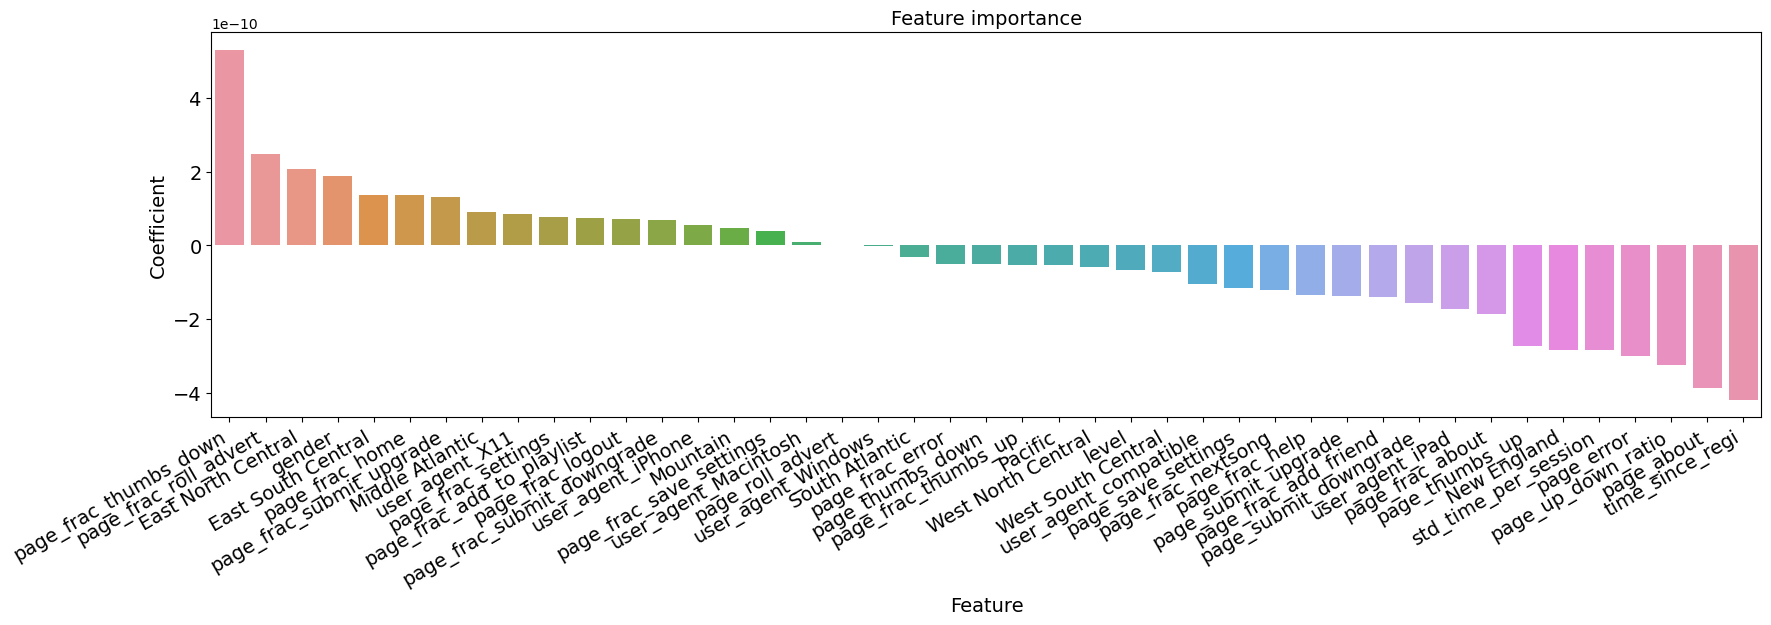

In [165]:
# Load the best model
bestCLModel = joblib.load("logistic.pkl")

# Feature importance
feature_coef = bestCLModel.coef_[0]
feature_coef_df = pd.DataFrame(list(zip(feature_cols, feature_coef)), columns=['Feature', 'Coefficient'])\
    .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Coefficient', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.show()


In [166]:
print(feature_cols)

n = len(feature_cols)
print(n)

['level', 'time_since_regi', 'gender', 'std_time_per_session', 'user_agent_Macintosh', 'user_agent_Windows', 'user_agent_X11', 'user_agent_compatible', 'user_agent_iPad', 'user_agent_iPhone', 'page_about', 'page_error', 'page_roll_advert', 'page_save_settings', 'page_submit_downgrade', 'page_submit_upgrade', 'page_thumbs_down', 'page_thumbs_up', 'page_frac_about', 'page_frac_add_friend', 'page_frac_add_to_playlist', 'page_frac_error', 'page_frac_help', 'page_frac_home', 'page_frac_logout', 'page_frac_nextsong', 'page_frac_roll_advert', 'page_frac_save_settings', 'page_frac_settings', 'page_frac_submit_downgrade', 'page_frac_submit_upgrade', 'page_frac_thumbs_down', 'page_frac_thumbs_up', 'page_up_down_ratio', 'East North Central', 'East South Central', 'Middle Atlantic', 'Mountain', 'New England', 'Pacific', 'South Atlantic', 'West North Central', 'West South Central']
43


## Random Forest

In [167]:
# Define the classifier
classifier = RandomForestClassifier()

# Define the parameter grid
param_grid = {}

# Train the model
grid_search = GridSearchCV(classifier, param_grid, cv=3, scoring='f1_weighted')
grid_search.fit(train.drop(columns=['churn']), train['churn'])

# Get the best model
best_model = grid_search.best_estimator_

# Save the best model (assuming you want to save it as a pickle file)
import joblib
joblib.dump(best_model, "random_forest.pkl")

# Evaluate model performance
pred_train = best_model.predict(train.drop(columns=['churn']))
pred_test = best_model.predict(test.drop(columns=['churn']))

evalMetrics = {}
evalMetrics["f1_train"] = f1_score(train['churn'], pred_train, average='weighted')
evalMetrics["acc_train"] = accuracy_score(train['churn'], pred_train)
evalMetrics["f1_test"] = f1_score(test['churn'], pred_test, average='weighted')
evalMetrics["acc_test"] = accuracy_score(test['churn'], pred_test)

# Display metrics
print("Random Forest:")
print("F1 score (train):", evalMetrics["f1_train"])
print("Accuracy (train):", evalMetrics["acc_train"])
print("F1 score (test):", evalMetrics["f1_test"])
print("Accuracy (test):", evalMetrics["acc_test"])


Random Forest:
F1 score (train): 1.0
Accuracy (train): 1.0
F1 score (test): 0.6810810810810811
Accuracy (test): 0.7333333333333333


### Important Features

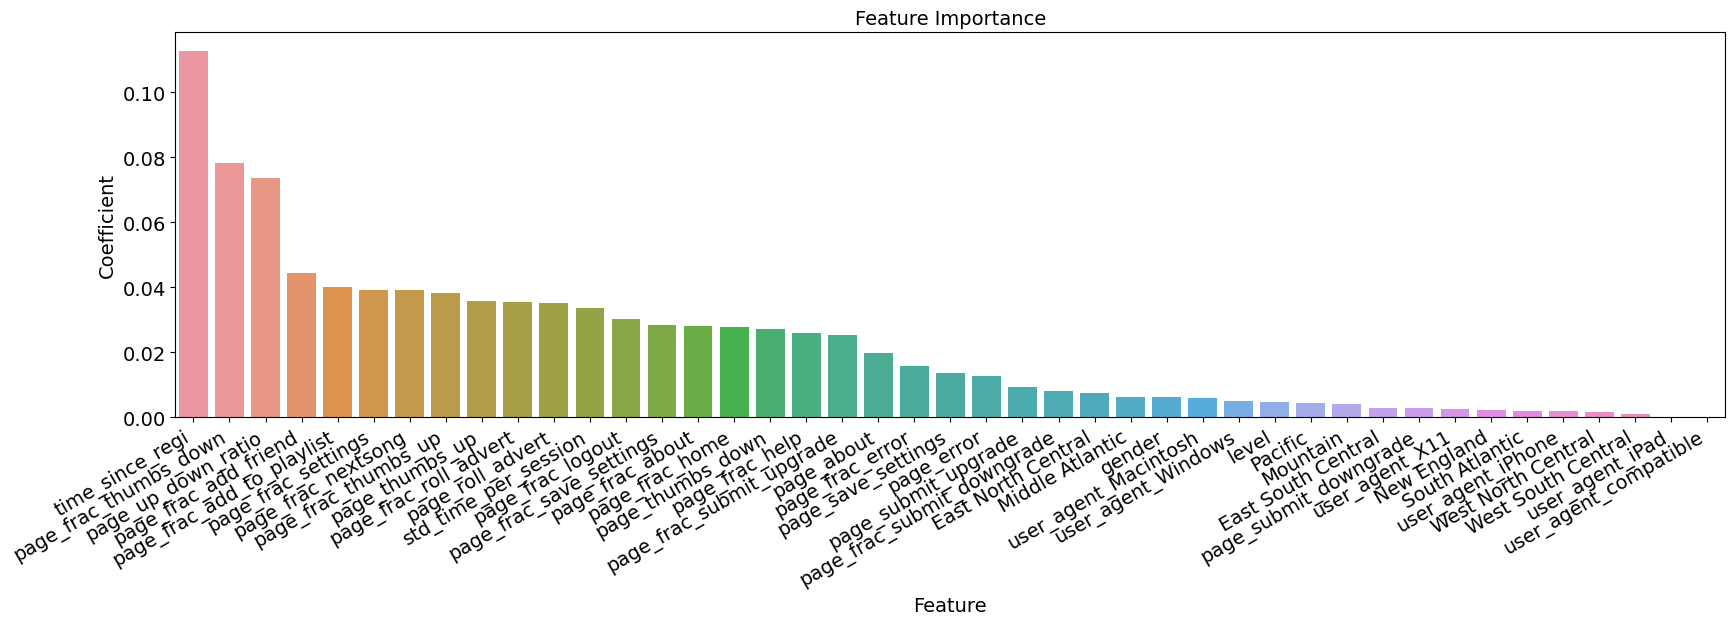

In [168]:
# Load the best model
bestCLModel = joblib.load("random_forest.pkl")

# Feature importance
feature_importance = bestCLModel.feature_importances_

# Trim feature_importance to match the length of feature_cols
feature_importance = feature_importance[:len(feature_cols)]

# Create DataFrame for feature importance
feature_coef_df = pd.DataFrame({'Feature': feature_cols, 'Coefficient': feature_importance}) \
    .sort_values('Coefficient', ascending=False)

# Plot feature importance
plt.figure(figsize=(20, 5))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature Importance', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Coefficient', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.show()


## Hyper parameter tuning

In [169]:
# Define classifier
classifier = RandomForestClassifier()

# Define parameter grid
param_grid = {
    'n_estimators': [20, 75],
    'max_depth': [10, 20]
}

# Perform Grid Search
start = time.time()
grid_search = GridSearchCV(classifier, param_grid, cv=3, scoring='f1_weighted')
grid_search.fit(train.drop(columns=['churn']), train['churn'])
end = time.time()
training_time = end - start

# Best model
best_model = grid_search.best_estimator_

# Evaluate model performance
train_pred = best_model.predict(train.drop(columns=['churn']))
test_pred = best_model.predict(test.drop(columns=['churn']))

evalMetrics = {
    "precision_train": precision_score(train['churn'], train_pred, average='weighted'),
    "recall_train": recall_score(train['churn'], train_pred, average='weighted'),
    "f1_train": f1_score(train['churn'], train_pred, average='weighted'),
    "accuracy_train": accuracy_score(train['churn'], train_pred),
    "precision_test": precision_score(test['churn'], test_pred, average='weighted'),
    "recall_test": recall_score(test['churn'], test_pred, average='weighted'),
    "f1_test": f1_score(test['churn'], test_pred, average='weighted'),
    "accuracy_test": accuracy_score(test['churn'], test_pred),
    "training_time": training_time
}

# Display metrics
print("Best model evaluation metrics:")
for metric, value in evalMetrics.items():
    print(f"{metric}: {value}")

# Best model parameters
print("Best model parameters:")
print(grid_search.best_params_)


Best model evaluation metrics:
precision_train: 1.0
recall_train: 1.0
f1_train: 1.0
accuracy_train: 1.0
precision_test: 0.8
recall_test: 0.8
f1_test: 0.7684125705076552
accuracy_test: 0.8
training_time: 0.887265682220459
Best model parameters:
{'max_depth': 10, 'n_estimators': 20}


### Important Features

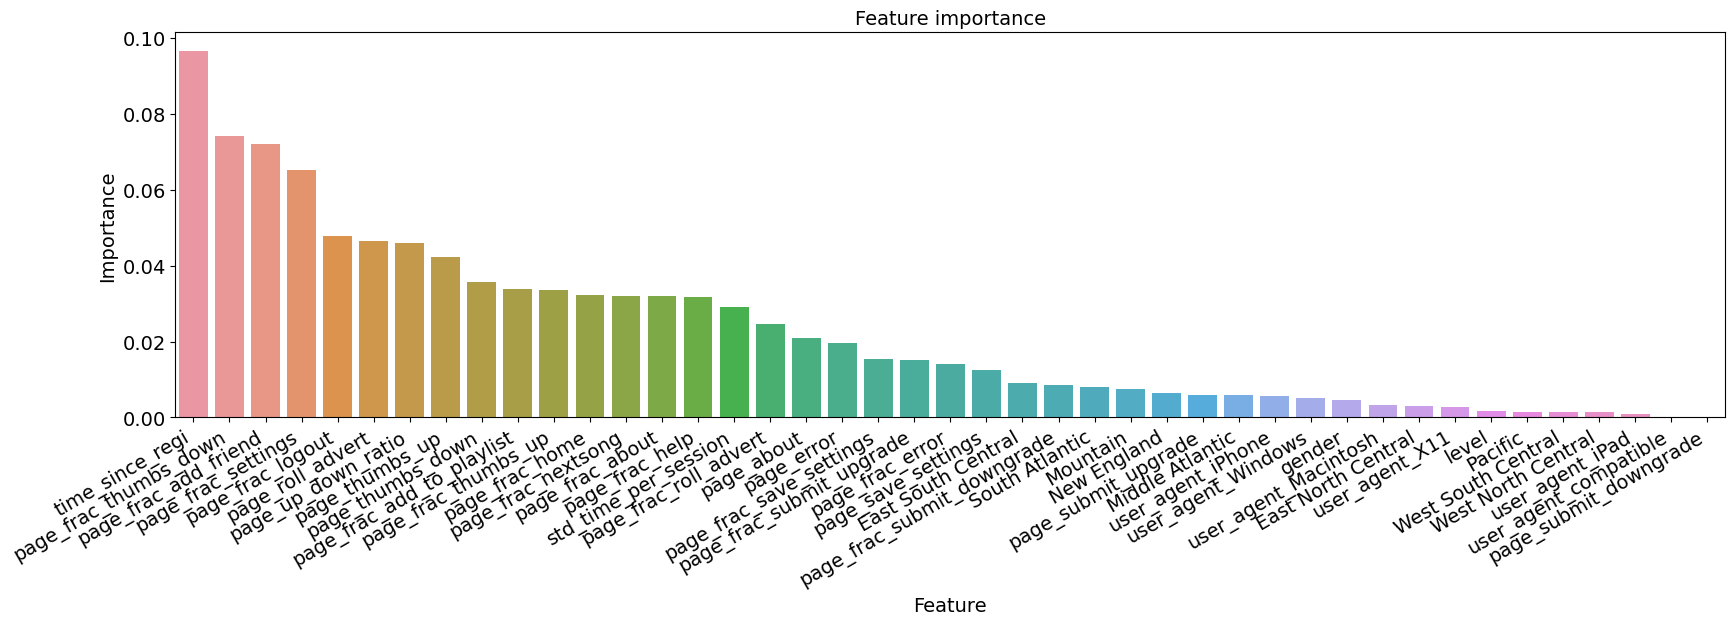

In [170]:
# Best model and parameters
best_model = grid_search.best_estimator_

# Feature importance
feature_importance = best_model.feature_importances_
feature_importance_dict = dict(zip(feature_cols, feature_importance))

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
feature_names = [feature[0] for feature in sorted_features]
feature_importance_values = [feature[1] for feature in sorted_features]

# Plot the feature importance
plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names, y=feature_importance_values)
plt.title('Feature importance', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.show()


### Top 25 most important features

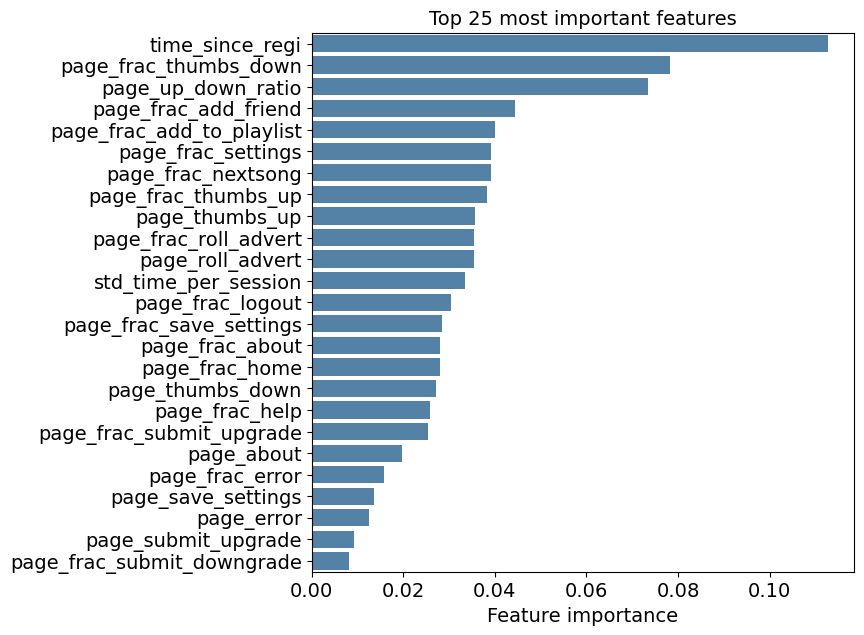

In [171]:
# Plot the top 25 most important features
plt.figure(figsize=(7, 7))
sns.barplot(x='Coefficient', y='Feature', data=feature_coef_df.head(25), color='steelblue')
plt.title('Top 25 most important features', fontsize=14)
plt.xlabel('Feature importance', fontsize=14)
plt.ylabel('', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
